In [1]:
import tensorflow as tf
import os
from glob import glob
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.metrics import MeanIoU

In [2]:
seed = 42
np.random.seed = seed

input_shape = (256,256,1)

breast_dir = "/kaggle/input/multi-cancer/Dataset/Breast scans"
benign_train_images = sorted(glob(os.path.join(breast_dir,"benign","Train")+"/*).png"))
benign_test_images = sorted(glob(os.path.join(breast_dir,"benign","Test")+"/*).png"))

malignant_train_images = sorted(glob(os.path.join(breast_dir,"malignant","Train")+"/*).png"))
malignant_test_images = sorted(glob(os.path.join(breast_dir,"malignant","Test")+"/*).png"))

normal_train_images = sorted(glob(os.path.join(breast_dir,"normal","Train")+"/*).png"))
normal_test_images = sorted(glob(os.path.join(breast_dir,"normal","Test")+"/*).png"))



len(benign_train_images),len(malignant_train_images),len(normal_train_images)

(398, 180, 103)

In [3]:
def get_images_mask(images_path, root_dir, dir1, dir2, input_shape=input_shape):
    x = np.zeros((len(images_path),input_shape[0],input_shape[1],input_shape[2]))
    y = np.zeros((len(images_path),input_shape[0],input_shape[1],1))
    for i,image in enumerate(images_path):
        img = resize(imread(image, as_gray=True),input_shape)
        x[i] = img
        for mask in list(filter(lambda x:image[:-4]+'_mask' in x, glob(os.path.join(root_dir,dir1,dir2)+'/*.png'))):
            msk = resize(imread(mask,as_gray=True),(input_shape[0],input_shape[1],1))
            y[i]+=msk
        if y[i].max()>0:
            y[i]/=y[i].max()
    return x,y

In [4]:
%%time
x_benign_train, y_benign_train = get_images_mask(benign_train_images, breast_dir, 'benign', 'Train', input_shape=input_shape)
x_benign_test, y_benign_test = get_images_mask(benign_test_images, breast_dir, 'benign', 'Test', input_shape=input_shape)

x_malignant_train, y_malignant_train = get_images_mask(malignant_train_images, breast_dir, 'malignant', 'Train', input_shape=input_shape)
x_malignant_test, y_malignant_test = get_images_mask(malignant_test_images, breast_dir, 'malignant', 'Test', input_shape=input_shape)

x_normal_train, y_normal_train = get_images_mask(normal_train_images, breast_dir, 'normal', 'Train', input_shape=input_shape)
x_normal_test, y_normal_test = get_images_mask(normal_test_images, breast_dir, 'normal', 'Test', input_shape=input_shape)


CPU times: user 24.3 s, sys: 1.11 s, total: 25.4 s
Wall time: 36.4 s


In [5]:
X_train = np.concatenate([x_benign_train, x_malignant_train])
X_test = np.concatenate([x_benign_test, x_malignant_test])

y_train = np.concatenate([y_benign_train, y_malignant_train])
y_test = np.concatenate([y_benign_test, y_malignant_test])

X_train.shape,y_train.shape, X_test.shape ,y_test.shape

((578, 256, 256, 1), (578, 256, 256, 1), (69, 256, 256, 1), (69, 256, 256, 1))

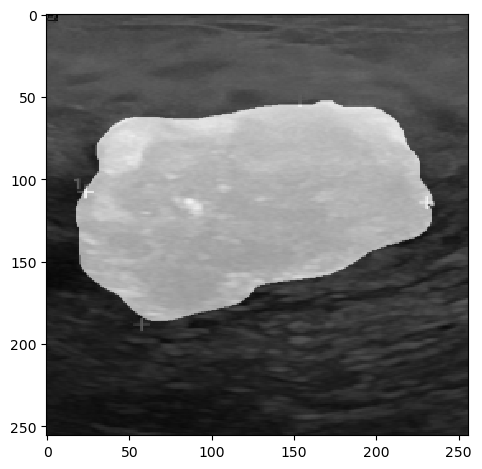

In [6]:
image_x = random.randint(0, len(X_train))
grayImage1_new = X_train[image_x]

grayImage2_new = y_train[image_x] 

alpha = 0.4
combined_image= np.zeros(grayImage1_new.shape,dtype=grayImage1_new.dtype)
combined_image[:,:,:] = (alpha * grayImage1_new[:,:,:]) + ((1-alpha) * grayImage2_new[:,:,:])
imshow(combined_image)

In [7]:
#Build the model
inputs = tf.keras.layers.Input(input_shape)
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', MeanIoU(num_classes=2, name='IoU')])
#model.summary()

In [8]:
#Modelcheckpoint
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='Breast_segmentation.h5', verbose=2, monitor="val_loss", save_best_only=True),
#     tf.keras.callbacks.EarlyStopping(patience=10, monitor='loss'),
#     tf.keras.callbacks.TensorBoard(log_dir='logs')
]

results = model.fit(X_train, y_train, 
                    validation_data=(X_test,y_test), 
                    batch_size=8, 
                    epochs=100, 
                    verbose=2,
                    callbacks=callbacks
                   )

Epoch 1/100


2023-04-17 14:11:48.699050: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_loss improved from inf to 0.34738, saving model to Breast_segmentation.h5
73/73 - 20s - loss: 0.3440 - accuracy: 0.8957 - IoU: 0.4592 - val_loss: 0.3474 - val_accuracy: 0.8497 - val_IoU: 0.4335 - 20s/epoch - 268ms/step
Epoch 2/100

Epoch 2: val_loss did not improve from 0.34738
73/73 - 4s - loss: 0.2679 - accuracy: 0.9047 - IoU: 0.4592 - val_loss: 0.3489 - val_accuracy: 0.8497 - val_IoU: 0.4335 - 4s/epoch - 53ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.34738 to 0.32934, saving model to Breast_segmentation.h5
73/73 - 4s - loss: 0.2490 - accuracy: 0.9047 - IoU: 0.4592 - val_loss: 0.3293 - val_accuracy: 0.8497 - val_IoU: 0.4335 - 4s/epoch - 56ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.32934
73/73 - 4s - loss: 0.2449 - accuracy: 0.9047 - IoU: 0.4592 - val_loss: 0.3296 - val_accuracy: 0.8497 - val_IoU: 0.4335 - 4s/epoch - 54ms/step
Epoch 5/100

Epoch 5: val_loss improved from 0.32934 to 0.32613, saving model to Breast_segmentation.h5
73/73 - 4s - 

3/3 [==============================] - 1s 19ms/step


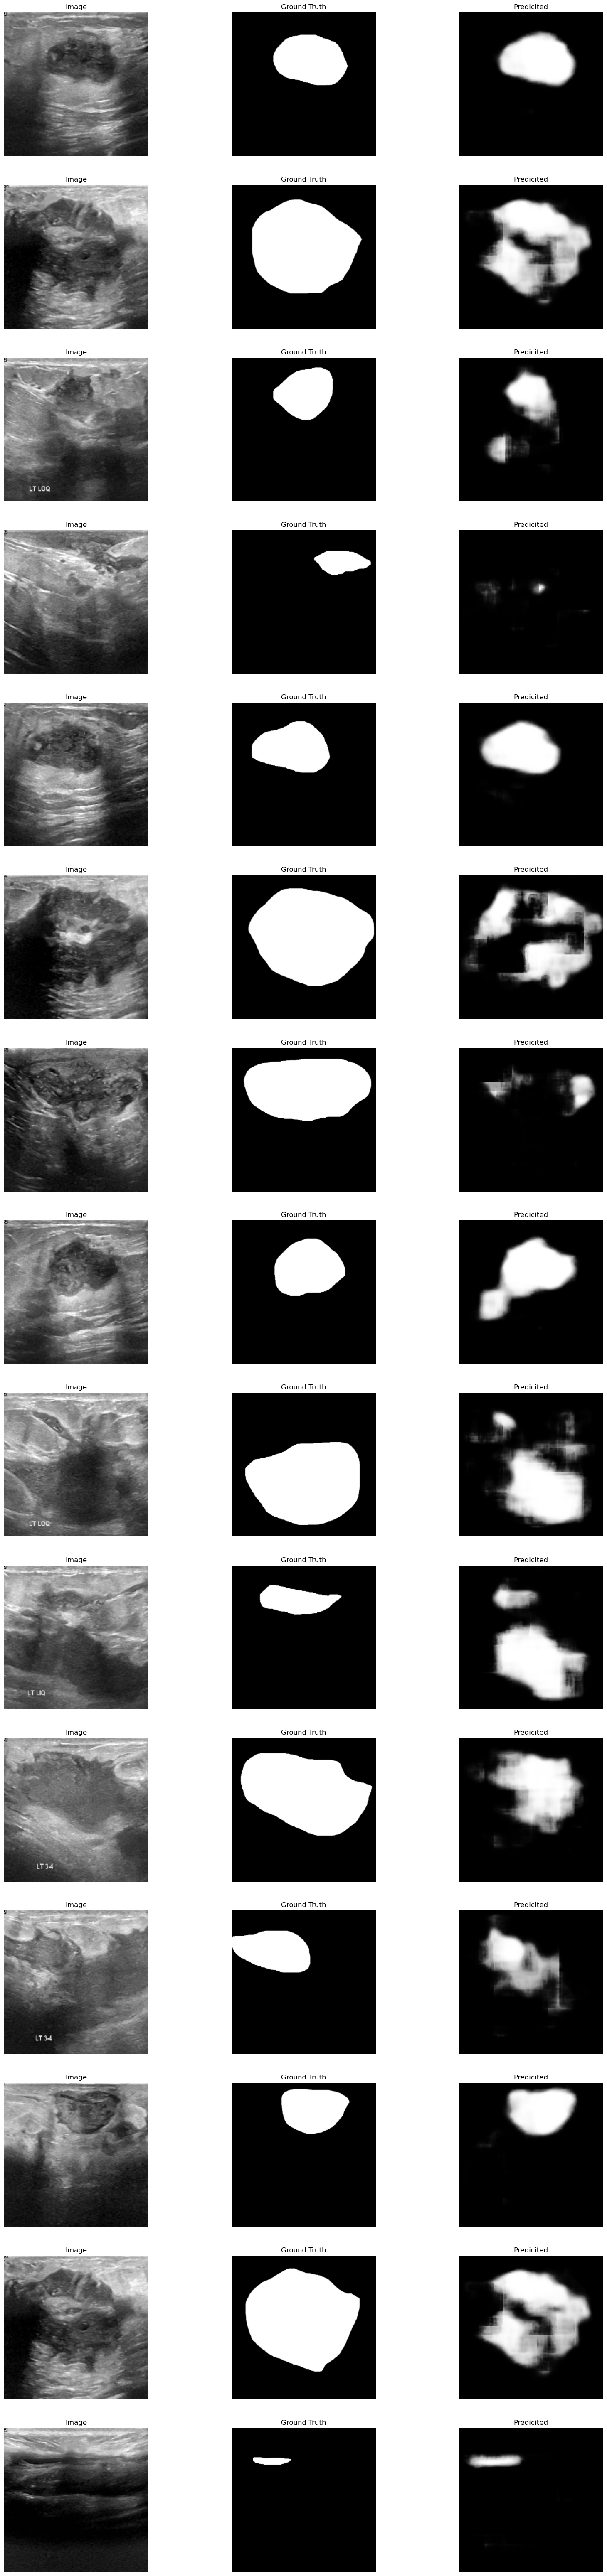

In [9]:
preds_test = model.predict(X_test, verbose=1)

plt.figure(figsize = (20,80))

i = 0
x = 0
while i < 45 :
    
    plt.subplot(15,3,i+1)
    plt.imshow(np.squeeze(X_test[x]), 'gray')
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(15,3,i+2)
    plt.imshow(np.squeeze(y_test[x]), 'gray')
    plt.title('Ground Truth')
    plt.axis('off')
    
    plt.subplot(15,3,i+3)
    plt.imshow(np.squeeze(preds_test[x]), 'gray')
    plt.title('Predicited')
    plt.axis('off')
    
    x += 1
    i += 3
plt.show()